- Test the robustness of findings under different high-risk group sizes: s_H=10^{-2,-1,1}; half-life=2 day; network of 10^5 nodes
- Reproduce Fig.4 in the paper 

In [1]:
import simsom.utils as utils
import numpy as np
import pandas as pd
import os
import glob

## Helpers

In [2]:
def get_agg_metric(
    df,
    group_key="base_name",
    new_col_prefix="baseline",
    metrics=[
        "quality",
        "illegal_frac",
        "unique_illegal_frac",
        "illegal_count",
        "unique_illegal_count",
    ],
):
    """
    Return a df where the columns of interest are aggregated by mean and std & renamed (prefix with a phrase)
    new_col_prefix (str): the prefix to append to aggregated cols
    """
    if "illegal_prob" not in df.columns:
        raise ValueError(
            "`illegal_prob` column not found in the dataframe. This is needed as a dummy column to count the number of observations."
        )
    for metric in metrics:
        df[f"{metric}_std"] = df[metric]
        df = df.rename(columns={metric: f"{metric}_mean"})

    # aggregate (by mean or std)
    agg = dict()
    agg["illegal_prob"] = "count"
    for metric in metrics:
        agg[f"{metric}_mean"] = "mean"
        agg[f"{metric}_std"] = "std"
    try:
        agg_df = df.groupby(group_key).agg(agg).reset_index()
        # rename aggregated cols with the prefix
        agg_cols = (
            [f"{metric}_mean" for metric in metrics]
            + [f"{metric}_std" for metric in metrics]
            + ["illegal_prob"]
        )
        rename_dict = {col: f"{new_col_prefix}_{col}" for col in agg_cols}
        rename_dict["illegal_prob"] = f"{new_col_prefix}_no_observations"
        agg_df = agg_df[agg_cols + [group_key]].rename(columns=rename_dict)
    except Exception as e:
        print(e)
        raise ValueError(
            "Unable to groupby or rename col, most likely the specified group_key or retain_cols don't exist."
        )
    return agg_df


def get_delay_from_name(string):
    # 4_0.01__diff_true -> 4
    delay = string.split("__")[0].split("_")[0]
    if delay != "b":
        return float(delay)
    else:
        return -1

# Helpers 
## Format violin plot

In [3]:
import seaborn as sns

# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

## Extract s_H from name

In [4]:
import re


def extract_float(input_str):
    # Define the regular expression pattern to match the float
    pattern = r"[a-zA-Z0-9]_(\d+(\.\d+)?)__diff_true"

    # Search for the pattern in the input string
    match = re.search(pattern, input_str)

    # If a match is found, extract the float part
    if match:
        return float(match.group(1))
    else:
        raise ValueError("The input string does not match the expected format")


# Example usage
input_str1 = "1_1__diff_true"
input_str2 = "b_10__diff_true"

extracted_float1 = extract_float(input_str1)
extracted_float2 = extract_float(input_str2)

print(extracted_float1)  # Output: 0.002
print(extracted_float2)  # Output: 0.002

1.0
10.0


## Bonferroni correction

In [5]:
def bonferroni_correction(p_value, n_comparisons):
    """
    Perform Bonferroni correction on a given p-value for multiple comparisons.
    Parameters:
    -----------
    - p_value (float): The original p-value.
    - n_comparisons (int): The number of comparisons being made.
    Returns:
    -----------
    - float: The Bonferroni corrected p-value.
    """
    bonferroni_corrected_p_value = p_value * n_comparisons
    # Ensure the corrected p-value is not greater than 1
    bonferroni_corrected_p_value = min(1.0, bonferroni_corrected_p_value)
    return bonferroni_corrected_p_value

# Prevalence: Read data

In [46]:
# Directory containing experiment results
ABS_PATH = "/N/u/baotruon/BigRed200/carisma/experiments/20241126_robustness"
fpaths = glob.glob(f"{ABS_PATH}/prevalence*/*.parquet")
dfs = []
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    raw = pd.read_parquet(fpath, engine="pyarrow")
    dfs += [raw]
combined = pd.concat(dfs, ignore_index=True)

Processing 0/54
Processing 5/54
Processing 10/54
Processing 15/54
Processing 20/54
Processing 25/54
Processing 30/54
Processing 35/54
Processing 40/54
Processing 45/54
Processing 50/54


In [47]:
combined["base_name"] = combined["fpath"].apply(lambda x: os.path.basename(x))
combined["illegal_prob"] = combined["base_name"].apply(extract_float)
print("illegal prob values:", combined["illegal_prob"].unique())
print("len combined data: ", len(combined))
data = combined[~combined["unique_illegal_frac"].isna()]
print("len combined data (after removing nans): ", len(data))

illegal prob values: [0.0009 0.002  0.01   0.0001 0.001  0.009  0.0003]
len combined data:  302
len combined data (after removing nans):  302


In [48]:
data['is_base'] = data['base_name'].apply(lambda x: 'b_' in x)
data.groupby(["moderation_half_life", "is_base"]).size()

moderation_half_life  is_base
0.5                   True       150
1.0                   False        8
2.0                   False      144
dtype: int64

--> Let's use half_life=2

In [49]:
data = data[(data["moderation_half_life"] ==2)|((data["moderation_half_life"] == 0.5) & (data["is_base"] == True))]

In [50]:
data.groupby(["moderation_half_life", "is_base"]).size()


moderation_half_life  is_base
0.5                   True       150
2.0                   False      144
dtype: int64

In [51]:
retain_cols = [
    # "illegal_frac",
    "unique_illegal_frac",
    # "illegal_count",
    # "unique_illegal_count",
    "illegal_prob",
    "is_base",
    "base_name"
]
data = data[retain_cols]
data.head()

,unique_illegal_frac,illegal_prob,is_base,base_name
0,0.001216,0.0009,True,b_0.0009__diff_true.json.gz
1,0.001807,0.0020,True,b_0.002__diff_true.json.gz
2,0.009838,0.0100,True,b_0.01__diff_true.json.gz
3,0.000155,0.0001,True,b_0.0001__diff_true.json.gz
4,0.000990,0.0010,True,b_0.001__diff_true.json.gz


# Count number of observations for each param

## Baseline

In [12]:
# Count the number of rows for each combination of 'half_life' and 'illegal_content_probability'
data[data.is_base == True].groupby("illegal_prob").size()

illegal_prob
0.0001    10
0.0003    14
0.0009    19
0.0010    21
0.0020    31
0.0090    34
0.0100    34
dtype: int64

## Non-baseline

In [13]:
# Count the number of rows for each combination of 'moderation_half_life' and 'illegal_content_probability'
row_counts = (
    data[data.is_base == False].groupby(["illegal_prob"]).size().reset_index(name="count")
)

# Display the result
row_counts.sort_values(by=["illegal_prob"])

,illegal_prob,count
0,0.0001,8
1,0.0003,11
2,0.0009,22
3,0.0010,15
4,0.0020,23
5,0.0090,32
6,0.0100,36


# Test another way

## Baseline

In [52]:
baseline = data[data.is_base == True]

In [53]:
# assign an index to baseline exp name, so we can match it with a non-baseline exp
# Create the new column with name and index using groupby and cumcount
# e.g: if there are 3 files with the same config, basename= b_0.001__diff_true, the new column indexed_basename will be b_0.001__diff_true_0, b_0.001__diff_true_1, b_0.001__diff_true_2
baseline["indexed_basename"] = (
    baseline.groupby("base_name").cumcount().apply(lambda x: f"_{x}")
)

# Concatenate the original 'name' column with the new suffix
baseline["indexed_basename"] = (
    baseline["base_name"] + baseline["indexed_basename"]
)

# baseline.indexed_basename

/tmp/ipykernel_116861/4194183152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline["indexed_basename"] = (
/tmp/ipykernel_116861/4194183152.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline["indexed_basename"] = (


## Non-baseline

In [54]:
print("Filtering non-baseline results...")

res = data[data.is_base == False]
# Note that the last index of the network config matches that of the exp config (e.g: we want to run illegal_prob = illegal_spreader_frac=0.01)
# e.g: 50__diff_false has the baseline of b0__diff_false
# b_0.01__diff_true
def get_base_name(string):
    return "b" + string[1:]


# merge mod=True with baseline (mod=False) so that each record has 2 cols: metric_baseline and metric
# We then use these 2 cols to calculate relative metrics
res["baseline_name"] = res["base_name"].apply(lambda x: get_base_name(x))

## Index name for non-baseline exp
# Create the new column with name and index using groupby and cumcount
res["indexed_basename"] = (
    res.groupby("baseline_name").cumcount().apply(lambda x: f"_{x}")
)

# Concatenate the original 'name' column with the new suffix
res["indexed_basename"] = res["baseline_name"] + res["indexed_basename"]

Filtering non-baseline results...


/tmp/ipykernel_116861/1016345276.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["baseline_name"] = res["base_name"].apply(lambda x: get_base_name(x))
/tmp/ipykernel_116861/1016345276.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["indexed_basename"] = (
/tmp/ipykernel_116861/1016345276.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [55]:
res.head()

,unique_illegal_frac,illegal_prob,is_base,base_name,baseline_name,indexed_basename
5,0.003506,0.0090,False,1_0.009__diff_true.json.gz,b_0.009__diff_true.json.gz,b_0.009__diff_true.json.gz_0
6,0.000077,0.0001,False,1_0.0001__diff_true.json.gz,b_0.0001__diff_true.json.gz,b_0.0001__diff_true.json.gz_0
7,0.003814,0.0100,False,1_0.01__diff_true.json.gz,b_0.01__diff_true.json.gz,b_0.01__diff_true.json.gz_0
10,0.000104,0.0003,False,1_0.0003__diff_true.json.gz,b_0.0003__diff_true.json.gz,b_0.0003__diff_true.json.gz_0
15,0.000542,0.0020,False,1_0.002__diff_true.json.gz,b_0.002__diff_true.json.gz,b_0.002__diff_true.json.gz_0


In [56]:
res.indexed_basename.unique()

array(['b_0.009__diff_true.json.gz_0', 'b_0.0001__diff_true.json.gz_0',
       'b_0.01__diff_true.json.gz_0', 'b_0.0003__diff_true.json.gz_0',
       'b_0.002__diff_true.json.gz_0', 'b_0.009__diff_true.json.gz_1',
       'b_0.001__diff_true.json.gz_0', 'b_0.01__diff_true.json.gz_1',
       'b_0.0009__diff_true.json.gz_0', 'b_0.002__diff_true.json.gz_1',
       'b_0.009__diff_true.json.gz_2', 'b_0.001__diff_true.json.gz_1',
       'b_0.01__diff_true.json.gz_2', 'b_0.0009__diff_true.json.gz_1',
       'b_0.002__diff_true.json.gz_2', 'b_0.009__diff_true.json.gz_3',
       'b_0.01__diff_true.json.gz_3', 'b_0.0009__diff_true.json.gz_2',
       'b_0.0003__diff_true.json.gz_1', 'b_0.009__diff_true.json.gz_4',
       'b_0.001__diff_true.json.gz_2', 'b_0.01__diff_true.json.gz_4',
       'b_0.0009__diff_true.json.gz_3', 'b_0.002__diff_true.json.gz_3',
       'b_0.009__diff_true.json.gz_5', 'b_0.01__diff_true.json.gz_5',
       'b_0.0009__diff_true.json.gz_4', 'b_0.002__diff_true.json.gz_4',
    

## Data frame of removal-no removal pairs for scatter plot

In [58]:
metric = "unique_illegal_frac"

baseline = baseline.rename(columns={f"{metric}": f"baseline_{metric}"})
focal_scatter = pd.merge(
    baseline[["indexed_basename", "base_name", f"baseline_{metric}"]],
    res[
        [
            "illegal_prob",
            "indexed_basename",
            metric,
        ]
    ],
    on="indexed_basename",
    how="left",
)
focal_scatter.head()

,indexed_basename,base_name,baseline_unique_illegal_frac,illegal_prob,unique_illegal_frac
0,b_0.0009__diff_true.json.gz_0,b_0.0009__diff_true.json.gz,0.001216,0.0009,0.000305
1,b_0.002__diff_true.json.gz_0,b_0.002__diff_true.json.gz,0.001807,0.0020,0.000542
2,b_0.01__diff_true.json.gz_0,b_0.01__diff_true.json.gz,0.009838,0.0100,0.003814
3,b_0.0001__diff_true.json.gz_0,b_0.0001__diff_true.json.gz,0.000155,0.0001,0.000077
4,b_0.001__diff_true.json.gz_0,b_0.001__diff_true.json.gz,0.000990,0.0010,0.000333


In [59]:
focal_scatter.base_name.unique()

array(['b_0.0009__diff_true.json.gz', 'b_0.002__diff_true.json.gz',
       'b_0.01__diff_true.json.gz', 'b_0.0001__diff_true.json.gz',
       'b_0.001__diff_true.json.gz', 'b_0.009__diff_true.json.gz',
       'b_0.0003__diff_true.json.gz'], dtype=object)

In [60]:
focal_scatter.shape

(150, 5)

# Check volume of actual illegal vs illegal probability

In [62]:
# exclude exps that haven't finished
focal_scatter = focal_scatter.dropna(subset=["illegal_prob"])
focal_scatter.corr()

/tmp/ipykernel_116861/2526349331.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  focal_scatter.corr()


,baseline_unique_illegal_frac,illegal_prob,unique_illegal_frac
baseline_unique_illegal_frac,1.000000,0.996283,0.990746
illegal_prob,0.996283,1.000000,0.991247
unique_illegal_frac,0.990746,0.991247,1.000000


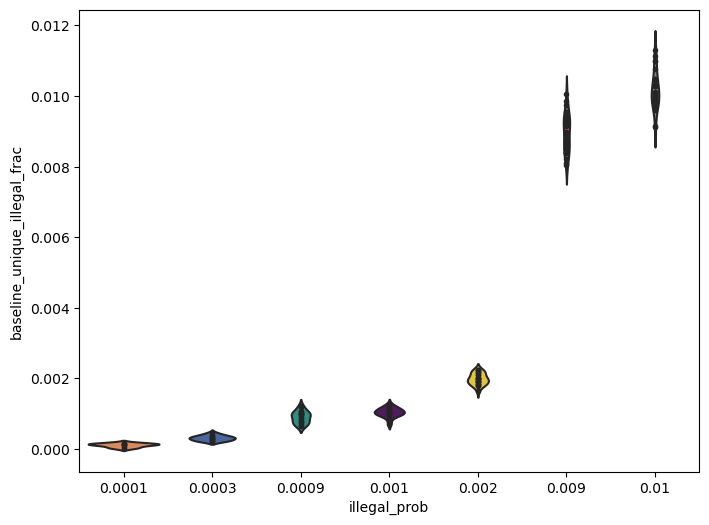

In [65]:
import matplotlib.pyplot as plt

BLUEPALETTE = [
    "#F18447",
    "#3863AC",
    "#209B8A",
    "#550F6B",
    "#F8D625",
    "#BC3684",
    "#808080",
    "#000000",
]
PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)


fpath = os.path.join(PLOT_DIR, "violin_baseline_illegal_prob")
# plot_data= focal[~((focal.illegal_content_probability==0.0009) | (focal.illegal_content_probability==0.001))]
moderation_half_life = 2

plot_data = focal_scatter.dropna(subset=["illegal_prob"])
probs = set(plot_data.illegal_prob)

fig, ax = plt.subplots(figsize=(8, 6))
# ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")

violin = sns.violinplot(
    data=plot_data,
    x="illegal_prob",
    y="baseline_unique_illegal_frac",
    order=sorted(probs),
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

# # violin.set(yticklabels=[])
# violin.tick_params(axis="x", labelsize=20)
# violin.tick_params(axis="y", labelsize=20)
# violin.set_ylabel("Relative illegal prevalence", fontsize=25, labelpad=14)
# violin.set_xlabel("Illegal content probability", fontsize=25, labelpad=14)
# patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
# point_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
# sns.despine(top=True, left=True, bottom=False)
# # Saving
# plt.tight_layout()

# # fig = violin.get_figure()
# # if fpath is not None:
# #     fig.savefig(f"{fpath}.pdf")
# #     fig.savefig(f"{fpath}.png")
# # else:
# #     plt.show()

Looks correct. But the resulting unique illegal frac is not exactly equal to illegal content probability 

In [66]:
focal_scatter.describe()

,baseline_unique_illegal_frac,illegal_prob,unique_illegal_frac
count,135.000000,135.000000,135.000000
mean,0.004724,0.004690,0.001762
std,0.004251,0.004204,0.001581
min,0.000026,0.000100,0.000025
25%,0.000977,0.000900,0.000358
50%,0.002023,0.002000,0.000782
75%,0.009319,0.009000,0.003419
max,0.011292,0.010000,0.004638


# Plot scatter

(1e-05, 0.1)

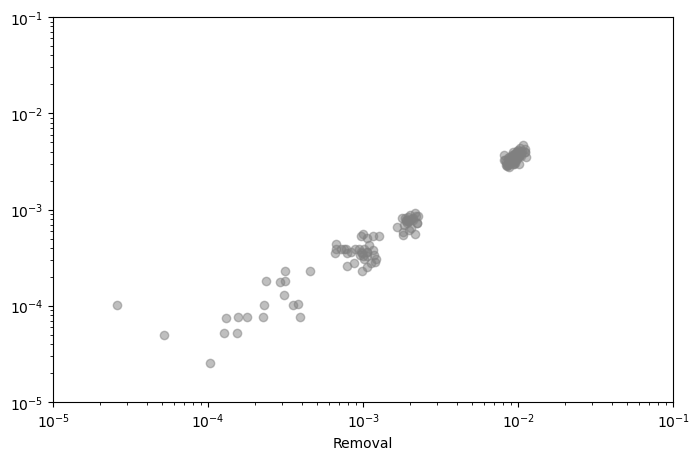

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
scatterplot_data = focal_scatter
x = scatterplot_data.baseline_unique_illegal_frac
y = scatterplot_data.unique_illegal_frac
ax.scatter(x, y, color="grey", zorder=1, alpha=0.5)
ax.set_xlabel("No removal")
ax.set_xlabel("Removal")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1e-1)
ax.set_xlim(1e-5, 1e-1)

## Scatter with regression line

Slope: 0.92
R-squared: 0.96
p-val: 0.00
std_err: 0.02
MSE: 1.50e-02


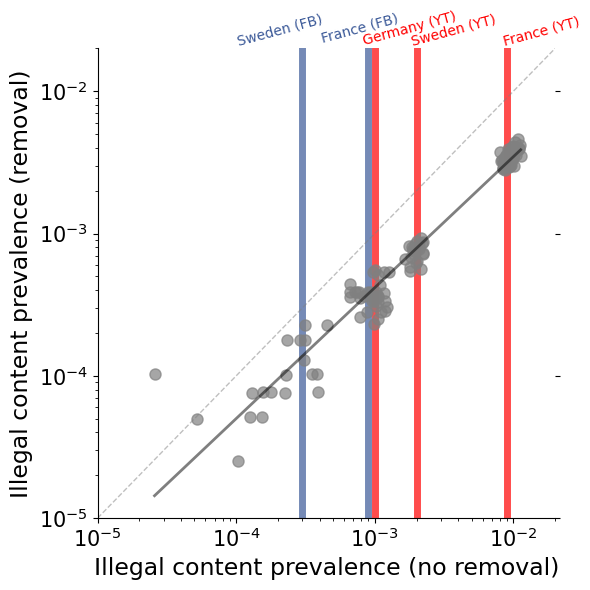

In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

plt.style.use("stylesheet_scatter.mplstyle")

PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

fpath = os.path.join(PLOT_DIR, "scatter_illegal_prob_regline_revised")

x_label = "Illegal content prevalence (no removal)"
y_label = "Illegal content prevalence (removal)"

fig, ax = plt.subplots(figsize=(6, 6))
scatterplot_data = focal_scatter
x = scatterplot_data.baseline_unique_illegal_frac
y = scatterplot_data.unique_illegal_frac
ax.scatter(x, y, color="grey", zorder=1, alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(np.log10(x), np.log10(y))

# Calculate predicted values and MSE
y_pred = 10 ** (slope * np.log10(x) + intercept)
mse = mean_squared_error(np.log10(y), np.log10(y_pred))

# Plot the regression line
x_vals = np.linspace(min(x), max(x), 100)
y_vals = 10 ** (slope * np.log10(x_vals) + intercept)
ax.plot(
    x_vals,
    y_vals,
    color="black",
    linestyle="-",
    alpha=0.5,
    linewidth=2,
    label=f"Regression line",
)
# guiding line
ax.plot(
    [1e-5, 5e-2],
    [1e-5, 5e-2],
    color="grey",
    linewidth=1,
    linestyle="--",
    alpha=0.5,
)
# # Print the coefficient and R-squared value on the plot
# ax.text(0.05, 0.95, f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}\np: {p_value**2:.2f}', transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
print(
    f"Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}\np-val: {p_value**2:.2f}\nstd_err: {std_err:.2f}\nMSE: {mse:.2e}"
)

ax.set_xlim(1e-5, 2e-2)
ax.set_ylim(1e-5, 2e-2)

# Plot dashed lines at specified values with alternating colors
label_mapping = {
    0.009: "France (YT)",
    0.0003: "Sweden (FB)",
    0.002: "Sweden (YT)",
    0.001: "Germany (YT)",
    0.0009: "France (FB)",
}
# Add labels to each point based on the mapping, only for the first occurrence
labeled_probs = set()
x_offsets = {
    0.009: -0.0008,  # "France (YT)",
    0.0003: -0.0002,  # "Sweden (FB)",
    0.002: -0.0002,  # "Sweden (YT)",
    0.001: -0.0002,  # "Germany (YT)",
    0.0009: -0.0005,  # "France (FB)"
}
y_offsets = {
    0.009: 0,  # "France (YT)",
    0.0003: 0,  # "Sweden (FB)",
    0.002: 0,  # "Sweden (YT)",
    0.001: 0,  # "Germany (YT)",
    0.0009: 0.001,  # "France (FB)"
}

for illegal_prob, label in label_mapping.items():
    x_val = illegal_prob
    x_offset = x_offsets[illegal_prob]
    y_offset = y_offsets[illegal_prob]
    if "FB" in label:
        color = "#3b5998"
        text_color = color
    if "YT" in label:
        color = "#FF0000"  # red
        # text_color = "black"
        text_color = color
    ax.axvline(
        x=x_val,
        color=color,
        linestyle="-",
        label=label,
        alpha=0.7,
        linewidth=5,
        zorder=-1,
    )
    ax.text(
        x_val + x_offset,
        ax.get_ylim()[1] + y_offset,
        label,
        rotation=15,
        verticalalignment="bottom",
        fontsize=10,
        color=text_color,
    )

# Additional plot settings
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
# ax.xaxis.set_major_locator(plt.LogLocator(base=10, numticks=len(x) + 1))
# ax.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=len(y) + 1))
sns.despine(top=True)
plt.tight_layout()

# Save the figure
fig.savefig(f"{fpath}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{fpath}.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Archive: Scatter data
Create df of removal - no removal pairs for scatter plot

This way is simplier but it doesn't give the desired result

## Baseline

In [ ]:
data.columns

Index(['illegal_frac', 'unique_illegal_frac', 'illegal_count',
       'unique_illegal_count', 'illegal_prob', 'is_base'],
      dtype='object')

In [ ]:
#create a new column since illegal_prob is used as a dummy column
# data['illegal_content_probability'] = data['illegal_prob']
retain_cols = ['unique_illegal_frac', 'illegal_prob']
baseline = data[data.is_base == True][retain_cols]

In [ ]:
res = data[data.is_base == False][retain_cols]
# ## Add baseline result to each row of removal result
# baseline = baseline.drop(columns=["illegal_content_probability"])
# focal = pd.concat([res, baseline], axis=1)
# new_baseline_cols = baseline.columns
# focal[new_baseline_cols] = focal[new_baseline_cols].fillna(method="ffill")

In [ ]:
focal = baseline.merge(res, on="illegal_prob", suffixes=("_base", "_removal"))

In [ ]:
focal.columns

Index(['unique_illegal_frac_base', 'illegal_prob',
       'unique_illegal_frac_removal'],
      dtype='object')

In [ ]:
focal.head()

,unique_illegal_frac_base,illegal_prob,unique_illegal_frac_removal
0,0.001216,0.0009,0.000305
1,0.001216,0.0009,0.000280
2,0.001216,0.0009,0.000390
3,0.001216,0.0009,0.000231
4,0.001216,0.0009,0.000386


In [ ]:
print("len focal data: ", len(focal))
focal=focal.drop_duplicates(subset=["unique_illegal_frac_base"])
print("len focal data: ", len(focal))

len focal data:  3992
len focal data:  163


In [ ]:
focal.head()

,unique_illegal_frac_base,illegal_prob,unique_illegal_frac_removal
0,0.001216,0.0009,0.000305
22,0.000874,0.0009,0.000305
44,0.000666,0.0009,0.000305
66,0.000981,0.0009,0.000305
88,0.000771,0.0009,0.000305


# Plot scatter

(1e-05, 0.1)

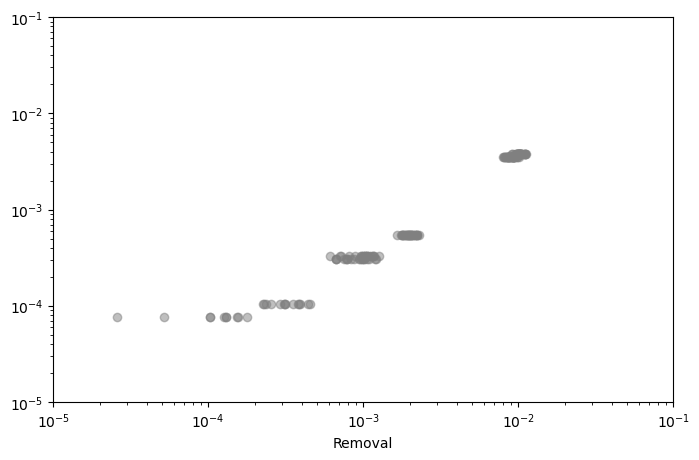

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
scatterplot_data = focal
x = scatterplot_data.unique_illegal_frac_base
y = scatterplot_data.unique_illegal_frac_removal
ax.scatter(x, y, color="grey", zorder=1, alpha=0.5)
ax.set_xlabel("No removal")
ax.set_xlabel("Removal")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1e-1)
ax.set_xlim(1e-5, 1e-1)